In [ ]:
!pip install --quiet --upgrade tensorflow tensorflow-federated

!pip install --upgrade packaging
!pip install --upgrade scipy

!pip install --upgrade typing-extensions

!pip uninstall pydantic -y
!pip install pydantic==1.10.2

!pip install --upgrade eth-account
!pip install --upgrade web3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.10.6 requires typing-extensions>=4.12.2, but you have typing-extensions 4.5.0 which is incompatible.
sphinx 8.1.3 requires packaging>=23.0, but you have packaging 22.0 which is incompatible.
altair 5.5.0 requires typing-extensions>=4.10.0; python_version < "3.14", but you have typing-extensions 4.5.0 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
optax 0.2.4 requires jax>=0.4.27, but you have jax 0.4.14 which is incompatible.
optax 0.2.4 requires jaxlib>=0.4.27, but you have jaxlib 0.4.14 which is incompatible.
orbax-checkpoint 0.6.4 requires jax>=0.4.26, but you have jax 0.4.14 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

from web3 import Web3
import matplotlib.pyplot as plt

# ***LOADING DATA***

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]
data = pd.read_csv(url, header=None, names=column_names, na_values=" ?", skipinitialspace=True)
data.dropna(inplace=True)
data.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


# ***PREPROCESSING***

In [ ]:
data = pd.get_dummies(data, columns=[
    "workclass", "education", "marital_status", "occupation", "relationship",
    "race", "sex", "native_country"
])
data["income"] = data["income"].apply(lambda x: 1 if x == ">50K" else 0)

numerical_columns = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
data[numerical_columns] = (data[numerical_columns] - data[numerical_columns].mean()) / data[numerical_columns].std()

feature_group_a = ["age", "education_num", "capital_gain", "capital_loss"]
feature_group_b = ["fnlwgt", "hours_per_week"] + [col for col in data.columns if col.startswith("workclass")]

X_a = data[feature_group_a].values.astype(np.float32)
X_b = data[feature_group_b].values.astype(np.float32)
y = data["income"].values.astype(np.float32).reshape(-1, 1)

# ***ADJUSTING THE MODEL***

In [ ]:
def create_federated_data(X, y, num_participants):
    X_splits = np.array_split(X, num_participants)
    y_splits = np.array_split(y, num_participants)
    return list(zip(X_splits, y_splits))

def preprocess(client_data):
    def to_dataset(data):
        x, y = data
        return tf.data.Dataset.from_tensor_slices((x, y)).batch(32)
    return [to_dataset(data) for data in client_data]

num_participants = 10  # Number of participants
federated_data = preprocess(create_federated_data(X_a, y, num_participants))

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_a.shape[1],)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def model_fn():
    keras_model = build_model()
    input_spec = (
        tf.TensorSpec(shape=[None, X_a.shape[1]], dtype=tf.float32),
        tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
    )
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

client_optimizer_fn = lambda: tf.keras.optimizers.Adam(learning_rate=0.01)
server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.5)

federated_training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn,
    server_optimizer_fn=server_optimizer_fn
)

# ***THE SMART CONTRACT DETAILS FROM GANACHE, REMIX AND NGROK***

In [ ]:
"""
THE SOLIDITY CODE ON Remix IDE:
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract FederatedLearningConsent {
    address public owner;
    mapping(address => bool) public hasConsented;

    event ConsentGiven(address participant);
    event ConsentRevoked(address participant);

    constructor() {
        owner = msg.sender;
    }

    modifier onlyOwner() {
        require(msg.sender == owner, "Not authorized");
        _;
    }

    function giveConsent() public {
        hasConsented[msg.sender] = true;
        emit ConsentGiven(msg.sender);
    }

    function revokeConsent(address participant) public onlyOwner {
        hasConsented[participant] = false;
        emit ConsentRevoked(participant);
    }

    function checkConsent(address participant) public view returns (bool) {
        return hasConsented[participant];
    }
}

COMPILE IT ON Remix IDE GET THE ABI AND DEPLOY IT TO GET THE CONTRACT ADDRESS
"""

'\nTHE SOLIDITY CODE ON Remix IDE:\n// SPDX-License-Identifier: MIT\npragma solidity ^0.8.0;\n\ncontract FederatedLearningConsent {\n    address public owner;\n    mapping(address => bool) public hasConsented;\n\n    event ConsentGiven(address participant);\n    event ConsentRevoked(address participant);\n\n    constructor() {\n        owner = msg.sender;\n    }\n\n    modifier onlyOwner() {\n        require(msg.sender == owner, "Not authorized");\n        _;\n    }\n\n    function giveConsent() public {\n        hasConsented[msg.sender] = true;\n        emit ConsentGiven(msg.sender);\n    }\n\n    function revokeConsent(address participant) public onlyOwner {\n        hasConsented[participant] = false;\n        emit ConsentRevoked(participant);\n    }\n\n    function checkConsent(address participant) public view returns (bool) {\n        return hasConsented[participant];\n    }\n}\n\nCOMPILE IT ON Remix IDE GET THE ABI AND DEPLOY IT TO GET THE CONTRACT ADDRESS\n'

In [ ]:
"""
THE SMART CONTRACT DETAILS FROM Remix IDE ::
ABI :
[
	{
		"anonymous": False,
		"inputs": [
			{
				"indexed": False,
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "ConsentGiven",
		"type": "event"
	},
	{
		"anonymous": False,
		"inputs": [
			{
				"indexed": False,
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "ConsentRevoked",
		"type": "event"
	},
	{
		"inputs": [],
		"name": "giveConsent",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "revokeConsent",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [],
		"stateMutability": "nonpayable",
		"type": "constructor"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "checkConsent",
		"outputs": [
			{
				"internalType": "bool",
				"name": "",
				"type": "bool"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "",
				"type": "address"
			}
		],
		"name": "hasConsented",
		"outputs": [
			{
				"internalType": "bool",
				"name": "",
				"type": "bool"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [],
		"name": "owner",
		"outputs": [
			{
				"internalType": "address",
				"name": "",
				"type": "address"
			}
		],
		"stateMutability": "view",
		"type": "function"
	}
]
Bytecode:
608060405234801561001057600080fd5b50336000806101000a81548173ffffffffffffffffffffffffffffffffffffffff021916908373ffffffffffffffffffffffffffffffffffffffff1602179055506104d8806100606000396000f3fe608060405234801561001057600080fd5b50600436106100575760003560e01c8063071db8141461005c5780634bf80d391461008c5780638da5cb5b14610096578063c5e6cf52146100b4578063d1a48627146100e4575b600080fd5b6100766004803603810190610071919061035f565b610100565b6040516100839190610401565b60405180910390f35b610094610120565b005b61009e6101b0565b6040516100ab91906103e6565b60405180910390f35b6100ce60048036038101906100c9919061035f565b6101d4565b6040516100db9190610401565b60405180910390f35b6100fe60048036038101906100f9919061035f565b61022a565b005b60016020528060005260406000206000915054906101000a900460ff1681565b60018060003373ffffffffffffffffffffffffffffffffffffffff1673ffffffffffffffffffffffffffffffffffffffff16815260200190815260200160002060006101000a81548160ff0219169083151502179055507ff802beea9846518e0e2cc4daa9a79947a808591e9a4fdac545e3c217d500fc25336040516101a691906103e6565b60405180910390a1565b60008054906101000a900473ffffffffffffffffffffffffffffffffffffffff1681565b6000600160008373ffffffffffffffffffffffffffffffffffffffff1673ffffffffffffffffffffffffffffffffffffffff16815260200190815260200160002060009054906101000a900460ff169050919050565b60008054906101000a900473ffffffffffffffffffffffffffffffffffffffff1673ffffffffffffffffffffffffffffffffffffffff163373ffffffffffffffffffffffffffffffffffffffff16146102b8576040517f08c379a00000000000000000000000000000000000000000000000000000000081526004016102af9061041c565b60405180910390fd5b6000600160008373ffffffffffffffffffffffffffffffffffffffff1673ffffffffffffffffffffffffffffffffffffffff16815260200190815260200160002060006101000a81548160ff0219169083151502179055507fa89e27868b9c53e1b1f1de58b96d2b10b02801d30a7c070fc827e53a4ec0b71f8160405161033f91906103e6565b60405180910390a150565b6000813590506103598161048b565b92915050565b60006020828403121561037157600080fd5b600061037f8482850161034a565b91505092915050565b6103918161044d565b82525050565b6103a08161045f565b82525050565b60006103b3600e8361043c565b91507f4e6f7420617574686f72697a65640000000000000000000000000000000000006000830152602082019050919050565b60006020820190506103fb6000830184610388565b92915050565b60006020820190506104166000830184610397565b92915050565b60006020820190508181036000830152610435816103a6565b9050919050565b600082825260208201905092915050565b60006104588261046b565b9050919050565b60008115159050919050565b600073ffffffffffffffffffffffffffffffffffffffff82169050919050565b6104948161044d565b811461049f57600080fd5b5056fea264697066735822122013037972e38ddd345bb2e6262d87cf04e0e04801d5e5d2dd36f82faaea75b67764736f6c63430008000033

AFTER DEPLOYEMENT
CONTRACT ADDRESS:
0x221B44c796F63e109BB6b46F95930b81035699e2


"""

'\nTHE SMART CONTRACT DETAILS FROM Remix IDE ::\nABI :\n[\n\t{\n\t\t"anonymous": False,\n\t\t"inputs": [\n\t\t\t{\n\t\t\t\t"indexed": False,\n\t\t\t\t"internalType": "address",\n\t\t\t\t"name": "participant",\n\t\t\t\t"type": "address"\n\t\t\t}\n\t\t],\n\t\t"name": "ConsentGiven",\n\t\t"type": "event"\n\t},\n\t{\n\t\t"anonymous": False,\n\t\t"inputs": [\n\t\t\t{\n\t\t\t\t"indexed": False,\n\t\t\t\t"internalType": "address",\n\t\t\t\t"name": "participant",\n\t\t\t\t"type": "address"\n\t\t\t}\n\t\t],\n\t\t"name": "ConsentRevoked",\n\t\t"type": "event"\n\t},\n\t{\n\t\t"inputs": [],\n\t\t"name": "giveConsent",\n\t\t"outputs": [],\n\t\t"stateMutability": "nonpayable",\n\t\t"type": "function"\n\t},\n\t{\n\t\t"inputs": [\n\t\t\t{\n\t\t\t\t"internalType": "address",\n\t\t\t\t"name": "participant",\n\t\t\t\t"type": "address"\n\t\t\t}\n\t\t],\n\t\t"name": "revokeConsent",\n\t\t"outputs": [],\n\t\t"stateMutability": "nonpayable",\n\t\t"type": "function"\n\t},\n\t{\n\t\t"inputs": [],\n\t\t"stateMu

In [ ]:
"""
RUN ON TERMINAL:
$ ganache
get the GANACHE PORT: 127.0.0.1:8545

WE OPEN A NGROK ACCOUNT AND TAKE AN AUTHTOKEN FROM IT WHICH IS: 2t949wELgLjx6exPEGglSyUqHC6_83x9UgRYKiJ8BZGZ9fcPL
THEN RUN ON TERMINAL:

$ ngrok authtoken 2t949wELgLjx6exPEGglSyUqHC6_83x9UgRYKiJ8BZGZ9fcPL
$ ngrok http 8545


AND WE GET THIS INTERFACE FROM NGROK ON TERMINAL

"""

'\nRUN ON TERMINAL:\n$ ganache\nget the GANACHE PORT: 127.0.0.1:8545\n\nWE OPEN A NGROK ACCOUNT AND TAKE AN AUTHTOKEN FROM IT WHICH IS: 2t949wELgLjx6exPEGglSyUqHC6_83x9UgRYKiJ8BZGZ9fcPL\nTHEN RUN ON TERMINAL:\n\n$ ngrok authtoken 2t949wELgLjx6exPEGglSyUqHC6_83x9UgRYKiJ8BZGZ9fcPL\n$ ngrok http 8545\n\n\nAND WE GET THIS INTERFACE FROM NGROK ON TERMINAL\n\n'

In [ ]:
"""
ngrok :: https://8aaa-105-235-133-176.ngrok-free.app => IT'S NOT CONSTANT IT CHANGES EVERYTIME I RAN THE ngrok COMMANDS
ganache PORT: 127.0.0.1:8545
"""

"\nngrok :: https://8aaa-105-235-133-176.ngrok-free.app => IT'S NOT CONSTANT IT CHANGES EVERYTIME I RAN THE ngrok COMMANDS\nganache PORT: 127.0.0.1:8545\n"

In [ ]:
"""# ***BLOCKCHAIN SETUP***"""
ganache_url = "https://8aaa-105-235-133-176.ngrok-free.app"
web3 = Web3(Web3.HTTPProvider(ganache_url))

if web3.is_connected():
    print("🎉 Connected to Ganache via Colab!")
else:
    print("⚠️ Failed to connect!")

accounts = web3.eth.accounts
participant_addresses = accounts[:num_participants]

contract_address = "0x221B44c796F63e109BB6b46F95930b81035699e2"

contract_abi = [
	{
		"anonymous": False,
		"inputs": [
			{
				"indexed": False,
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "ConsentGiven",
		"type": "event"
	},
	{
		"anonymous": False,
		"inputs": [
			{
				"indexed": False,
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "ConsentRevoked",
		"type": "event"
	},
	{
		"inputs": [],
		"name": "giveConsent",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "revokeConsent",
		"outputs": [],
		"stateMutability": "nonpayable",
		"type": "function"
	},
	{
		"inputs": [],
		"stateMutability": "nonpayable",
		"type": "constructor"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "participant",
				"type": "address"
			}
		],
		"name": "checkConsent",
		"outputs": [
			{
				"internalType": "bool",
				"name": "",
				"type": "bool"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [
			{
				"internalType": "address",
				"name": "",
				"type": "address"
			}
		],
		"name": "hasConsented",
		"outputs": [
			{
				"internalType": "bool",
				"name": "",
				"type": "bool"
			}
		],
		"stateMutability": "view",
		"type": "function"
	},
	{
		"inputs": [],
		"name": "owner",
		"outputs": [
			{
				"internalType": "address",
				"name": "",
				"type": "address"
			}
		],
		"stateMutability": "view",
		"type": "function"
	}
]

contract = web3.eth.contract(address=contract_address, abi=contract_abi)


🎉 Connected to Ganache via Colab!


# ***INCLUDE THE SMART CONTRACT PART***

In [ ]:
ganache_url = "https://8aaa-105-235-133-176.ngrok-free.app"

web3 = Web3(Web3.HTTPProvider(ganache_url))

if web3.is_connected():
    print("🎉 Connected to Ganache via Colab!")
else:
    print("⚠️ Failed to connect!")

🎉 Connected to Ganache via Colab!


In [ ]:
accounts = web3.eth.accounts
accounts

['0x025D4f8357b62A4A892C049E3661D354E3EeD3d1',
 '0xfF678de70e1cf772098445bD140a7Ad9b3eD24e8',
 '0xC660bFc9B87635B3942bE660ca950f14Dcd57291',
 '0x487803B29dF0239693D375e65d5d9DC4666B85eB',
 '0xFe3755e3AF63a3b4427DA3c17917229690B13C0b',
 '0x403DE421a2F91c85c3b60e2cA625b8E115A71051',
 '0x26982F32Dab92f675825e19E3aAFA85aBBdAFc7C',
 '0x17Ed9317b6bE772924ff5BCa1c3C687800fA2C0f',
 '0x06aFB6E44e4F6adB76778D0547b68145C9A80489',
 '0x0813F3ae9440701600a208cD6A13c30A93C5F6Ee']

In [ ]:
account = accounts[0]
balance = web3.eth.get_balance(account)
print(f"Balance of {account}: {web3.from_wei(balance, 'ether')} ETH")

Balance of 0x025D4f8357b62A4A892C049E3661D354E3EeD3d1: 999.999576171844132267 ETH


# ***TRAINING***

In [ ]:
code = web3.eth.get_code(contract_address)
if code.hex() == '0x':
    print("⚠️ No contract deployed at the specified address!")
else:
    print("✅ Contract code found at the specified address!")

for func in contract.all_functions():
    print(f"Contract function: {func.fn_name}")

try:
    status = contract.functions.checkConsent(participant_addresses[0]).call()
    print(f"Consent status for {participant_addresses[0]}: {status}")
except Exception as e:
    print(f"Error calling checkConsent: {e}")

✅ Contract code found at the specified address!
Contract function: checkConsent
Contract function: giveConsent
Contract function: hasConsented
Contract function: owner
Contract function: revokeConsent
Consent status for 0x025D4f8357b62A4A892C049E3661D354E3EeD3d1: True


In [ ]:
def check_and_grant_consent(participant_address):
    try:
        status = contract.functions.checkConsent(participant_address).call()
        print(f"🔍 Checking consent for {participant_address}: {'Given' if status else 'Not Given'}")

        if not status:
            print(f"🚀 Granting consent for: {participant_address}")
            tx_hash = contract.functions.giveConsent().transact({
                'from': participant_address,
                'gas': 3000000
            })
            web3.eth.wait_for_transaction_receipt(tx_hash)
            print(f"✅ Consent granted for: {participant_address}")
            return True
        else:
            return True

    except Exception as e:
        print(f"❌ Error processing consent for {participant_address}: {e}")
        return False


🔄 Starting Round 1:
🔍 Checking consent for 0x025D4f8357b62A4A892C049E3661D354E3EeD3d1: Given
Round 1, Client 1 - Training allowed
🔍 Checking consent for 0xfF678de70e1cf772098445bD140a7Ad9b3eD24e8: Given
Round 1, Client 2 - Training allowed
🔍 Checking consent for 0xC660bFc9B87635B3942bE660ca950f14Dcd57291: Given
Round 1, Client 3 - Training allowed
🔍 Checking consent for 0x487803B29dF0239693D375e65d5d9DC4666B85eB: Given
Round 1, Client 4 - Training allowed
🔍 Checking consent for 0xFe3755e3AF63a3b4427DA3c17917229690B13C0b: Given
Round 1, Client 5 - Training allowed
🔍 Checking consent for 0x403DE421a2F91c85c3b60e2cA625b8E115A71051: Given
Round 1, Client 6 - Training allowed
🔍 Checking consent for 0x26982F32Dab92f675825e19E3aAFA85aBBdAFc7C: Given
Round 1, Client 7 - Training allowed
🔍 Checking consent for 0x17Ed9317b6bE772924ff5BCa1c3C687800fA2C0f: Given
Round 1, Client 8 - Training allowed
🔍 Checking consent for 0x06aFB6E44e4F6adB76778D0547b68145C9A80489: Given
Round 1, Client 9 - Traini

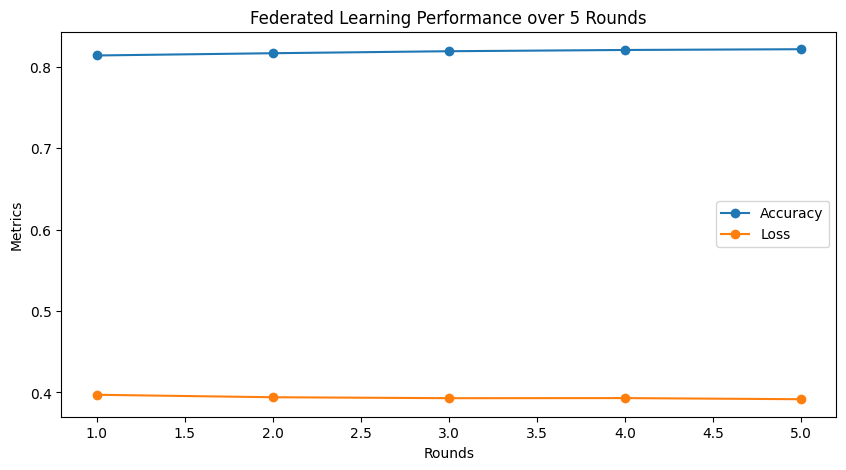

In [ ]:
num_rounds = 5
state = federated_training_process.initialize()
accuracies = []
losses = []

for round_num in range(1, num_rounds + 1):
    print(f"\n🔄 Starting Round {round_num}:")
    round_metrics = None

    for i, data in enumerate(federated_data):
        address = participant_addresses[i]

        if check_and_grant_consent(address):
            state, metrics = federated_training_process.next(state, [data])
            round_metrics = metrics
            print(f"Round {round_num}, Client {i+1} - Training allowed")
        else:
            print(f"Round {round_num}, Client {i+1} - Training blocked: Consent not given")

    if round_metrics is not None:
        print(f"Round {round_num} - Metrics: {round_metrics}")
        acc = round_metrics['client_work']['train']['binary_accuracy']
        loss = round_metrics['client_work']['train']['loss']
        accuracies.append(acc)
        losses.append(loss)
    else:
        print(f"Round {round_num} - No training occurred (all clients blocked).")

if accuracies and losses:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_rounds + 1), accuracies, label='Accuracy', marker='o')
    plt.plot(range(1, num_rounds + 1), losses, label='Loss', marker='o')
    plt.xlabel('Rounds')
    plt.ylabel('Metrics')
    plt.title('Federated Learning Performance over 5 Rounds')
    plt.legend()
    plt.show()
else:
    print("⚠️ No training data to plot.")